In [1]:
#!pip install datatable
#!pip install pycaret

In [2]:
import pandas as pd
import datatable as dt 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from pycaret.anomaly import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
monthyear = 'feb2022'

In [5]:
raw = pd.read_feather("../content/drive/MyDrive/RAFI/Fraud Detection/Data Sources/" + monthyear + "repayment.feather")

In [6]:
raw['Transaction Type'].value_counts()

Repayment    1297974
Name: Transaction Type, dtype: int64

In [7]:
raw = raw[raw['Transaction ID'] != 'Records from date:']

In [8]:
raw["Transaction Amount"] = pd.to_numeric(raw["Transaction Amount"], errors='coerce')
raw["Service Fee"] = pd.to_numeric(raw["Service Fee"], errors='coerce')
raw["Loan Amount"] = pd.to_numeric(raw["Loan Amount"], errors='coerce')
raw["Total Loan Outstanding (OLB)"] = pd.to_numeric(raw["Total Loan Outstanding (OLB)"], errors='coerce')
raw["Deposit Balance"] = pd.to_numeric(raw["Deposit Balance"], errors='coerce')
raw["Interest"] = pd.to_numeric(raw["Interest"], errors='coerce')
raw["Principal"] = pd.to_numeric(raw["Principal"], errors='coerce')
raw["Penalty"] = pd.to_numeric(raw["Penalty"], errors='coerce')
raw["Fee"] = pd.to_numeric(raw["Fee"], errors='coerce')
raw['Entry Time'] = raw['Entry Time'].astype('datetime64[ns]')
raw['Transaction Date'] = raw['Transaction Date'].astype('datetime64[ns]')

In [9]:
# Extract Time and Weekday
raw['Entry Hour'] = raw['Entry Time'].dt.hour
raw['Entry Day'] = raw['Entry Time'].dt.strftime("%A")

### Distribution of Raw Data (Population)

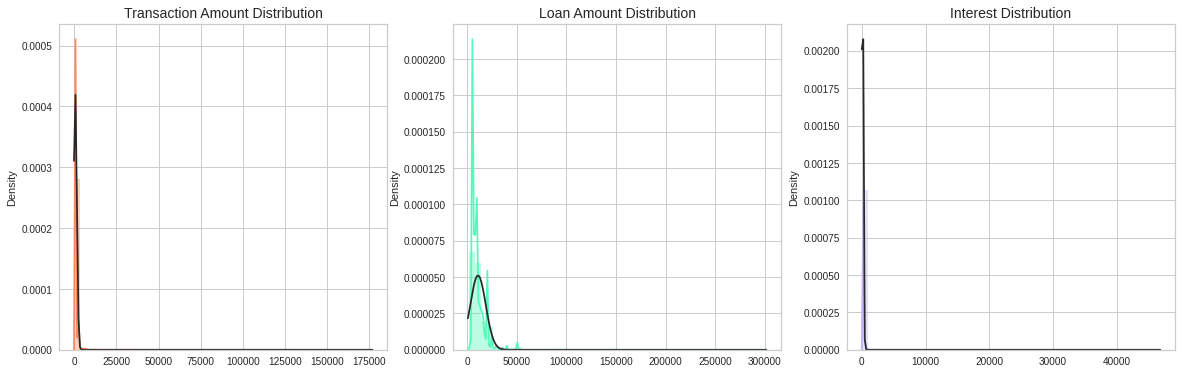

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = raw['Transaction Amount'].loc[raw['Transaction Type'] == 'Repayment'].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Transaction Amount Distribution', fontsize=14)

v12_fraud_dist = raw['Loan Amount'].loc[raw['Transaction Type'] == 'Repayment'].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Loan Amount Distribution', fontsize=14)


v10_fraud_dist = raw['Interest'].loc[raw['Transaction Type'] == 'Repayment'].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Interest Distribution', fontsize=14)

plt.show()

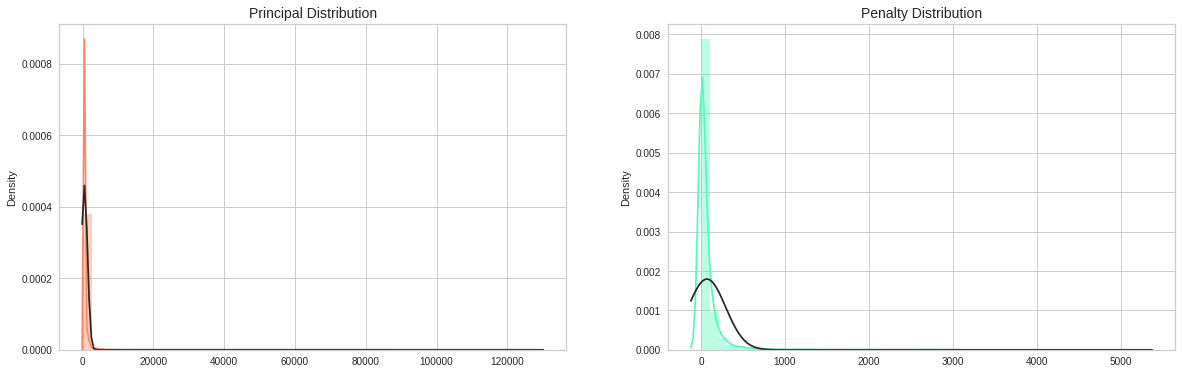

In [11]:
f, (ax1, ax2,) = plt.subplots(1,2, figsize=(20, 6))

v14_fraud_dist = raw['Principal'].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Principal Distribution', fontsize=14)

v12_fraud_dist = raw['Penalty'].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Penalty Distribution', fontsize=14)

plt.show()

## Getting the Sample

In [12]:
df = raw[raw['Transaction Type'] == 'Repayment']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297974 entries, 0 to 1297973
Data columns (total 36 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   Transaction ID                1297974 non-null  object        
 1   Client ID                     1297974 non-null  object        
 2   Branch                        1297974 non-null  object        
 3   First Name                    1297974 non-null  object        
 4   Middle Name                   1297915 non-null  object        
 5   Last Name                     1297974 non-null  object        
 6   Street                        1295203 non-null  object        
 7   Village                       1297709 non-null  object        
 8   City                          1297445 non-null  object        
 9   State                         1297974 non-null  object        
 10  Country                       1297974 non-null  object        
 11

In [14]:
df.describe()

,Transaction Amount,Service Fee,Loan Amount,Total Loan Outstanding (OLB),Deposit Balance,Interest,Principal,Penalty,Fee,Entry Hour
count,1.297974e+06,0.0,1.297974e+06,1.297974e+06,0.0,1.277119e+06,1.287702e+06,5122.000000,0.0,1.297974e+06
mean,5.737868e+02,NaN,1.081514e+04,7.127542e+03,NaN,9.712701e+01,4.817537e+02,70.745947,NaN,1.443399e+01
std,9.406027e+02,NaN,7.792217e+03,6.916810e+03,NaN,1.267762e+02,8.683153e+02,222.176503,NaN,2.261444e+00
min,1.000000e-02,NaN,2.000000e+03,0.000000e+00,NaN,1.000000e-02,1.000000e-02,0.010000,NaN,0.000000e+00
25%,2.500000e+02,NaN,5.000000e+03,3.000000e+03,NaN,4.123000e+01,2.119300e+02,1.670000,NaN,1.300000e+01
50%,4.000000e+02,NaN,9.000000e+03,5.334940e+03,NaN,6.973000e+01,3.145700e+02,11.985000,NaN,1.400000e+01
75%,6.000000e+02,NaN,1.300000e+04,9.200000e+03,NaN,1.210200e+02,4.886500e+02,72.690000,NaN,1.600000e+01
max,1.768026e+05,NaN,3.000000e+05,3.400045e+05,NaN,4.680257e+04,1.300000e+05,5254.470000,NaN,2.300000e+01


We have to exclude Service Fee, Deposit Balance, and Fee because these columns do not have data.

### Sample Size Calculation

Yamane' Formula (working with a finite population and the population size is known):

In [15]:
N = len(df.index)
e = 0.01

In [16]:
yamane = N / (1+N*e**2)
print(yamane)

9923.545880881424


In [17]:
# ceiling for sample size is 10% of the population; the greater the sample size, the better
if (yamane<len(df.index)*.1):
    N=len(df.index)*.1
else:
    N=yamane

In [18]:
#df=df.groupby('Branch', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

### Distribution of Sample

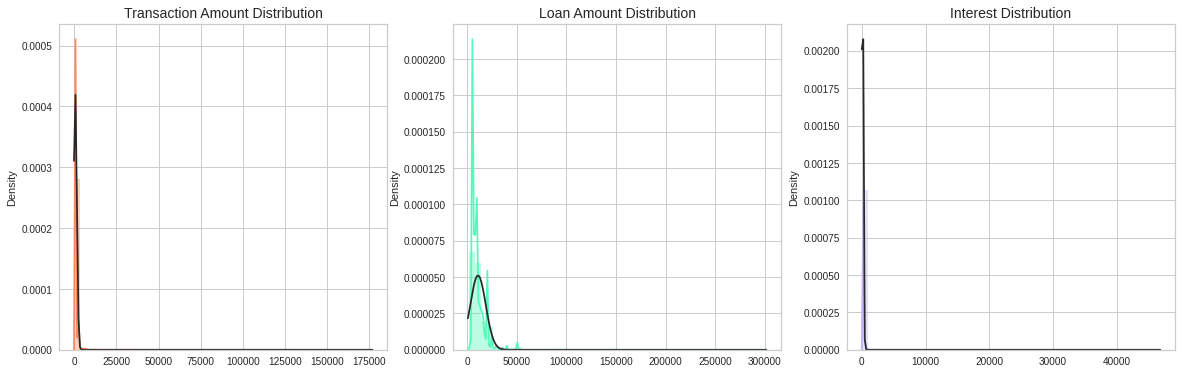

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = df['Transaction Amount'].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Transaction Amount Distribution', fontsize=14)

v12_fraud_dist = df['Loan Amount'].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Loan Amount Distribution', fontsize=14)


v10_fraud_dist = df['Interest'].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Interest Distribution', fontsize=14)

plt.show()

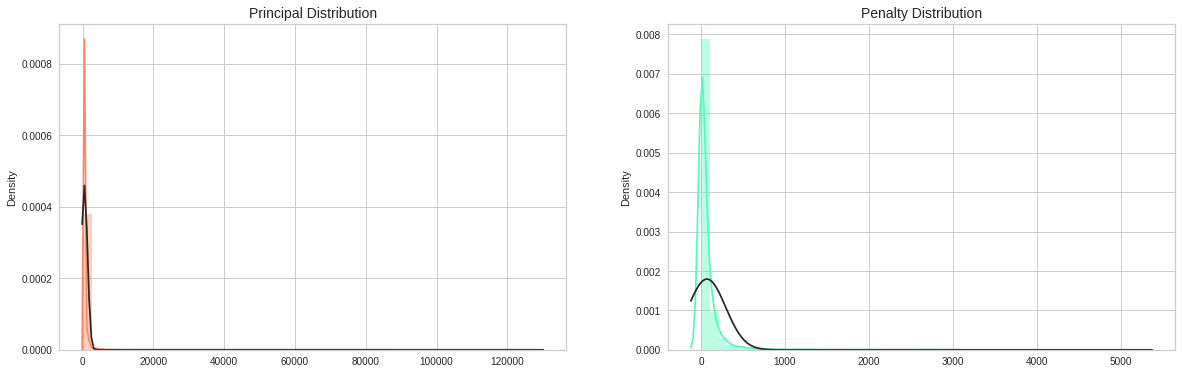

In [20]:
f, (ax1, ax2,) = plt.subplots(1,2, figsize=(20, 6))

v14_fraud_dist = df['Principal'].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Principal Distribution', fontsize=14)

v12_fraud_dist = df['Penalty'].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Penalty Distribution', fontsize=14)

plt.show()

The distribution of the sample is similar to the distribution of the population.

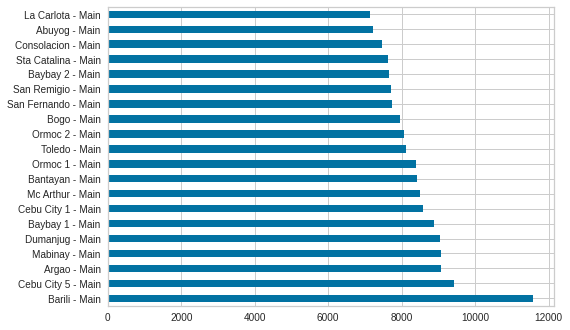

In [21]:
df['Branch'].value_counts()[:20].plot(kind='barh')

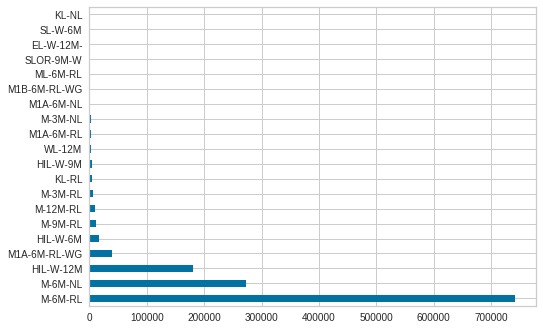

In [22]:
df['Loan Product ID'].value_counts()[:20].plot(kind='barh')

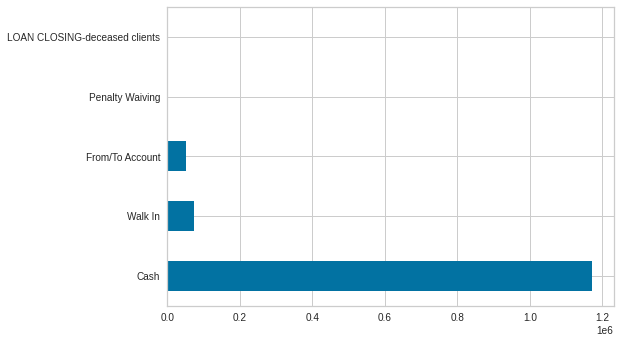

In [23]:
df['Payment Method'].value_counts().plot(kind='barh')

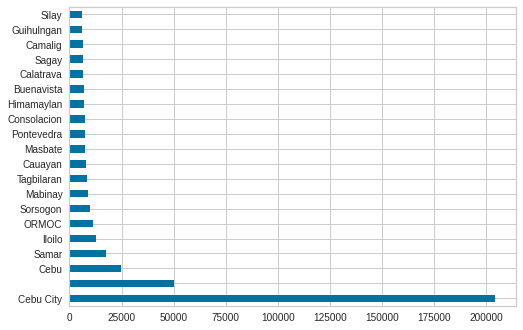

In [24]:
df['City'].value_counts()[:20].plot(kind='barh')

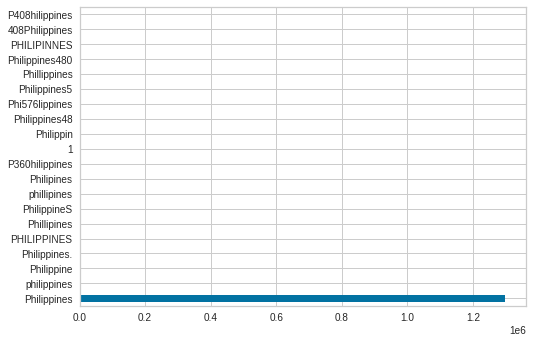

In [25]:
df['Country'].value_counts()[:20].plot(kind='barh')

## Anomaly Detection

In [26]:
test = df[['Transaction ID', 'Branch', 'Loan Product ID', 'Transaction Date', 'Entry Hour', 'Entry Day',
           'Entry Time', 'Payment Method', 'Transaction Amount', 'Interest', 'Penalty']]

In [ ]:
from pycaret.anomaly import *
s = setup(test,
          normalize=True,
          transformation=True,
         # high_cardinality_features=['Loan Product ID'], 
         # categorical_features=['Client ID'], 
          ignore_features=['Transaction ID'],
          #combine_rare_levels=True,
          remove_multicollinearity=True,
          session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(1297974, 11)"
2,Missing Values,True
3,Numeric Features,4
4,Categorical Features,4
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(1297974, 99)"
9,CPU Jobs,-1


In [ ]:
iforest = create_model('iforest', fraction = 0.05)
iforest_results = assign_model(iforest)
iforest_results.head()

,Transaction ID,Branch,Loan Product ID,Transaction Date,Entry Hour,Entry Day,Entry Time,Payment Method,Transaction Amount,Interest,Penalty,Anomaly,Anomaly_Score
0,56047498,Barili - Main,HIL-W-12M,2022-02-02,22,Monday,2022-02-14 22:28:27,Cash,240.00,52.76,NaN,0,-0.014148
1,56047486,Barili - Main,M-6M-RL,2022-02-02,22,Monday,2022-02-14 22:26:32,Cash,550.00,154.75,NaN,0,-0.033807
2,55179558,Leon - Main,M1A-6M-RL-WG,2022-02-04,9,Monday,2022-02-07 09:05:17,Cash,550.00,110.93,NaN,0,-0.025690
3,55179136,Ormoc 1 - Main,WL-12M,2022-02-05,8,Sunday,2022-02-06 08:38:53,From/To Account,2000.00,97.15,NaN,1,0.002235
4,55179134,Ormoc 1 - Main,M-6M-RL,2022-02-05,8,Sunday,2022-02-06 08:38:22,From/To Account,2491.45,544.41,NaN,0,-0.000119


### Save Model / Experiment

In [ ]:
# saving model
save_model(iforest, model_name = '/content/drive/MyDrive/RAFI/Fraud Detection/Data Sources/anomaly_detection_repayment_for_deployment'+ monthyear)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Transaction ID'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value...
                  Fix_multicollinearity(correlation_with_target_preference=None,
                                        correlation_with_target_threshold=0.0,
                                        target_variable='UNSUPERVISED_DUMMY_TARGET',
                      

## Predictions

In [ ]:
 repayment = raw[raw['Transaction Type'] == 'Repayment']

In [ ]:
predictions = predict_model(iforest, data=repayment)

In [ ]:
predictions = predictions[predictions['Anomaly'] == 1]
predictions.to_csv('/content/drive/MyDrive/RAFI/Fraud Detection/Data Sources/Repayment Predictions' + monthyear + '.csv', index=False)

Load Model

In [ ]:
#iforest = load_model('/content/drive/MyDrive/RAFI/Fraud Detection/Data Sources/anomaly_detection_repayment_for_deployment'+ monthyear)

In [ ]:
#iforest

In [ ]:
# plot model
plot_model(iforest, plot = 'tsne')

IntProgress(value=0, description='Processing: ', max=5)

In [ ]:
# plot model
plot_model(iforest, plot = 'umap')